# FenGen个性化联邦学习例子

In [ ]:
%load_ext autoreload
%autoreload 2

## 在secretflow环境创造3个实体[Alice，Bob，Charlie]，其中 Alice, Bob和Charlie 是三个PYU，Alice和Bob角色是client，Charlie角色是server。

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

/home/yang/anaconda3/envs/mysf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-20 20:02:39,315	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


The version of SecretFlow: 1.9.0.dev20240726


/home/yang/anaconda3/envs/mysf/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-20 20:02:42,035	INFO worker.py:1724 -- Started a local Ray instance.


In [3]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

In [4]:
## 导入相关依赖

In [5]:
from secretflow.ml.nn.core.torch import (
    metric_wrapper,
    optim_wrapper,
    BaseModule,
    TorchModel,
)
from secretflow.ml.nn import FLModel
from torchmetrics import Accuracy, Precision
from secretflow.security.aggregation import SecureAggregator
from secretflow.utils.simulation.datasets import load_mnist
from torch import nn, optim
from torch.nn import functional as F
import torch

2024-09-20 20:02:46.152676: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 数据划分，这里模拟数据不平衡2:8分

In [6]:
(train_data, train_label), (test_data, test_label) = load_mnist(
    parts={alice: 0.2, bob: 0.8},
    normalized_x=True,
    categorical_y=True,
    is_torch=True,
)

## 定义一个神经网络模型，输出是logit

In [7]:
class ConvNet(BaseModule):
    """Small ConvNet for MNIST."""

    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc_in_dim = 192
        self.fc = nn.Linear(self.fc_in_dim, 10)

    def forward(self, x, start_layer_idx=0):
        if start_layer_idx == -1:
            x = self.fc(x)
            return x
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.fc_in_dim)
        x = self.fc(x)
        return x

定义神经网络模型的损失函数和优化器

In [8]:
loss_fn = nn.CrossEntropyLoss
optim_fn = optim_wrapper(optim.Adam, lr=1e-2)

## 准备FedGen相关工作，生成器模型等

生成器模型

In [9]:
class GeneratorModel(BaseModule):
    def __init__(
        self, hidden_dimension, latent_dimension, n_class, noise_dim, embedding=False
    ):
        super(GeneratorModel, self).__init__()
        self.hidden_dim = hidden_dimension
        self.latent_dim = latent_dimension
        self.n_class = n_class
        self.noise_dim = noise_dim
        self.embedding = embedding
        input_dim = (
            self.noise_dim * 2 if self.embedding else self.noise_dim + self.n_class
        )
        self.build_network(input_dim)

    def build_network(self, input_dim):
        if self.embedding:
            self.embedding_layer = nn.Embedding(self.n_class, self.noise_dim)
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),
            nn.ReLU(),
        )
        # Representation layer
        self.representation_layer = nn.Linear(self.hidden_dim, self.latent_dim)
        # print(f"Build last layer {self.hidden_dim} X {self.latent_dim}")

    def forward(self, labels, latent_layer_idx=-1, verbose=True):
        """
        G(Z|y) or G(X|y):
        Generate either latent representation( latent_layer_idx < 0) or raw image (latent_layer_idx=0) conditional on labels.
        :param labels:
        :param latent_layer_idx:
            if -1, generate latent representation of the last layer,
            -2 for the 2nd to last layer, 0 for raw images.
        :param verbose: also return the sampled Gaussian noise if verbose = True
        :return: a dictionary of output information.
        """
        result = {}
        batch_size = labels.shape[0]
        eps = torch.rand((batch_size, self.noise_dim))  # sampling from Gaussian
        if verbose:
            result['eps'] = eps
        if self.embedding:  # embedded dense vector
            y_input = self.embedding_layer(labels)
        else:  # one-hot (sparse) vector
            y_input = torch.FloatTensor(batch_size, self.n_class)
            y_input.zero_()
            # labels = labels.view
            y_input.scatter_(1, labels.view(-1, 1), 1)
        z = torch.cat((eps, y_input), dim=1)
        ### FC layers
        for layer in self.fc_layers:
            z = layer(z)
        z = self.representation_layer(z)
        result['output'] = z
        return result


generator = GeneratorModel(
    hidden_dimension=256,
    latent_dimension=192,
    n_class=10,
    noise_dim=64,
    embedding=False,
)
print(generator)

GeneratorModel(
  (fc_layers): Sequential(
    (0): Linear(in_features=74, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (representation_layer): Linear(in_features=256, out_features=192, bias=True)
)


DiversityLoss是一个自定义的损失函数类

In [10]:
class DiversityLoss(nn.Module):
    """
    Diversity loss for improving the performance.
    """

    def __init__(self, metric):
        """
        Class initializer.
        """
        super().__init__()
        self.metric = metric
        self.cosine = nn.CosineSimilarity(dim=2)

    def compute_distance(self, tensor1, tensor2, metric):
        """
        Compute the distance between two tensors.
        """
        if metric == 'l1':
            return torch.abs(tensor1 - tensor2).mean(dim=(2,))
        elif metric == 'l2':
            return torch.pow(tensor1 - tensor2, 2).mean(dim=(2,))
        elif metric == 'cosine':
            return 1 - self.cosine(tensor1, tensor2)
        else:
            raise ValueError(metric)

    def pairwise_distance(self, tensor, how):
        """
        Compute the pairwise distances between a Tensor's rows.
        """
        n_data = tensor.size(0)
        tensor1 = tensor.expand((n_data, n_data, tensor.size(1)))
        tensor2 = tensor.unsqueeze(dim=1)
        return self.compute_distance(tensor1, tensor2, how)

    def forward(self, noises, layer):
        """
        Forward propagation.
        """
        if len(layer.shape) > 2:
            layer = layer.view((layer.size(0), -1))
        layer_dist = self.pairwise_distance(layer, how=self.metric)
        noise_dist = self.pairwise_distance(noises, how='l2')
        return torch.exp(torch.mean(-noise_dist * layer_dist))

FedGen需要有generator_config配置，关于生成器模型需要的损失函数，优化器等

In [11]:
kl_div_loss = nn.KLDivLoss(reduction="batchmean")
diversity_loss = DiversityLoss(metric='l1')
generative_optimizer = torch.optim.Adam(params=generator.parameters(), lr=1e-2)
cross_entropy_loss = nn.CrossEntropyLoss()
generator_config = {
    'generator_model': generator,
    'optimizer': generative_optimizer,
    'loss_fn': cross_entropy_loss,
    'kl_div_loss': kl_div_loss,
    'diversity_loss': diversity_loss,
    'num_classes': 10,
}

## 使用 Actor 进行生成器模型训练

In [12]:
from secretflow import proxy, PYUObject
import numpy as np


@proxy(PYUObject)
class FedGenServer(object):
    def generate_samples(self, generative_num_classes, generative_batch_size):
        y = np.random.choice(generative_num_classes, generative_batch_size)
        self.y_input = torch.LongTensor(y)
        generative_optimizer.zero_grad()
        self.gen_result = generator(self.y_input)
        return self.gen_result['output']

    def train_generator(
        self,
        user_results,
        worker_label_counts,
        generator,
        generative_num_classes,
        generative_optimizer,
        loss_fn,
        diversity_loss_fn,
    ):
        label_weights = []

        num_workers = len(worker_label_counts)

        # 遍历每个类别，计算权重
        for label in range(generative_num_classes):
            # 获取每个worker对该标签的计数
            weights = [
                worker_counts.get(label, 0) for worker_counts in worker_label_counts
            ]

            # 计算总和，避免除以0
            label_sum = np.sum(weights) + 1e-6  # 稍微增加容差，视数据规模调整

            # 计算该标签在所有worker中的权重
            label_weights.append(np.array(weights) / label_sum)

        # 将标签权重转换为 numpy 数组
        label_weights = np.array(label_weights).reshape(
            (generative_num_classes, num_workers)
        )

        # 准备训练
        generator.train()

        # 反向传播之前需要清除梯度
        generative_optimizer.zero_grad()

        gen_output, eps = self.gen_result['output'], self.gen_result['eps']

        # 计算多样性损失
        diversity_loss = diversity_loss_fn(eps, gen_output)

        # Get teacher loss
        teacher_loss = 0
        for idx in range(len(user_results)):
            weight = torch.tensor(
                label_weights[self.y_input][:, idx].reshape(-1, 1), dtype=torch.float32
            )
            user_result_given_gen = user_results[idx]

            # 计算每个worker的损失并加权
            teacher_loss_ = torch.mean(
                loss_fn(user_result_given_gen, self.y_input) * weight
            )
            teacher_loss += teacher_loss_

        # 总损失
        loss = teacher_loss + diversity_loss

        # 反向传播
        loss.backward()

        # 更新参数
        generative_optimizer.step()

## 进行联邦学习

In [13]:
model_def = TorchModel(
    model_fn=ConvNet,
    loss_fn=loss_fn,
    optim_fn=optim_fn,
    metrics=[
        metric_wrapper(Accuracy, task="multiclass", num_classes=10, average='micro'),
        metric_wrapper(Precision, task="multiclass", num_classes=10, average='micro'),
    ],
)

device_list = [alice, bob]
server_actor = FedGenServer(device=charlie)
aggregator = SecureAggregator(charlie, [alice, bob])

# spcify params
fl_model = FLModel(
    server=server_actor,
    device_list=device_list,
    model=model_def,
    strategy='fed_gen',  # fl strategy
    backend="torch",  # backend support ['tensorflow', 'torch']
    aggregator=aggregator,
    generator_config=generator_config,
)
history = fl_model.fit(
    train_data,
    train_label,
    validation_data=(test_data, test_label),
    epochs=20,
    batch_size=32,
    aggregate_freq=1,
)

INFO:root:Create proxy actor <class 'secretflow.device.proxy.ActorFedGenServer'> with party charlie.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.device.proxy.Actor_Masker'> with party bob.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedGen'> with party alice.
INFO:root:Create proxy actor <class 'abc.ActorPYUFedGen'> with party bob.
INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2c003c4bb0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2c003c4760>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7f2c003c4700>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7f2c003c46a0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 32, 'batch_

Epoch 1/20


Train Processing: :  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 373/375 [00:28<00:00, 14.84it/s]/home/yang/PycharmProjects/secretflow/secretflow/ml/nn/metrics.py:62: UserWarning: Please pay attention to local metrics, global only do naive aggregation.
  warnings.warn(
2024-09-20 20:03:27.757499: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Train Processing: : 100%|▉| 374/375 [00:28<00:00, 13.04it/s, {'multiclassaccuracy': 0.89109373, 'multiclassprecision': 0.89109373, 'val_multiclassaccuracy': 0.93562496, 'val_multic
Train Processing: :   0%|▎                                              

Epoch 2/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.1255192905664444, 'train_multiclassaccuracy': tensor(0.8917), 'train_multiclassprecision': tensor(0.8917), 'val_eval_multiclassaccuracy': tensor(0.9260), 'val_eval_multiclassprecision': tensor(0.9260)}


Train Processing: : 100%|▉| 374/375 [00:28<00:00, 13.14it/s, {'multiclassaccuracy': 0.9487604, 'multiclassprecision': 0.9487604, 'val_multiclassaccuracy': 0.94925, 'val_multiclassp


(ActorPYUFedGen pid=563149) {'train-loss': 0.10515822470188141, 'train_multiclassaccuracy': tensor(0.9488), 'train_multiclassprecision': tensor(0.9488), 'val_eval_multiclassaccuracy': tensor(0.9410), 'val_eval_multiclassprecision': tensor(0.9410)} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:53,  7.00it/s]

Epoch 3/20


Train Processing: : 100%|▉| 374/375 [00:28<00:00, 13.05it/s, {'multiclassaccuracy': 0.9555, 'multiclassprecision': 0.9555, 'val_multiclassaccuracy': 0.9565625, 'val_multiclasspreci
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:53,  7.03it/s]

Epoch 4/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.10342409461736679, 'train_multiclassaccuracy': tensor(0.9555), 'train_multiclassprecision': tensor(0.9555), 'val_eval_multiclassaccuracy': tensor(0.9495), 'val_eval_multiclassprecision': tensor(0.9495)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:29<00:00, 12.84it/s, {'multiclassaccuracy': 0.9585, 'multiclassprecision': 0.9585, 'val_multiclassaccuracy': 0.95631254, 'val_multiclassprec
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:49,  7.59it/s]

Epoch 5/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.108164943754673, 'train_multiclassaccuracy': tensor(0.9576), 'train_multiclassprecision': tensor(0.9576), 'val_eval_multiclassaccuracy': tensor(0.9495), 'val_eval_multiclassprecision': tensor(0.9495)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:29<00:00, 12.72it/s, {'multiclassaccuracy': 0.96046877, 'multiclassprecision': 0.96046877, 'val_multiclassaccuracy': 0.9576875, 'val_multicl
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:52,  7.12it/s]

Epoch 6/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.1124085783958435, 'train_multiclassaccuracy': tensor(0.9595), 'train_multiclassprecision': tensor(0.9595), 'val_eval_multiclassaccuracy': tensor(0.9505), 'val_eval_multiclassprecision': tensor(0.9505)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:29<00:00, 12.65it/s, {'multiclassaccuracy': 0.9612813, 'multiclassprecision': 0.9612813, 'val_multiclassaccuracy': 0.9579375, 'val_multiclas
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:52,  7.19it/s]

(ActorPYUFedGen pid=563149) {'train-loss': 0.1128455325961113, 'train_multiclassaccuracy': tensor(0.9602), 'train_multiclassprecision': tensor(0.9602), 'val_eval_multiclassaccuracy': tensor(0.9505), 'val_eval_multiclassprecision': tensor(0.9505)} [repeated 2x across cluster]
Epoch 7/20


Train Processing: : 100%|▉| 374/375 [00:29<00:00, 12.63it/s, {'multiclassaccuracy': 0.96187496, 'multiclassprecision': 0.96187496, 'val_multiclassaccuracy': 0.959125, 'val_multicla
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:50,  7.37it/s]

Epoch 8/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.11082722246646881, 'train_multiclassaccuracy': tensor(0.9607), 'train_multiclassprecision': tensor(0.9607), 'val_eval_multiclassaccuracy': tensor(0.9525), 'val_eval_multiclassprecision': tensor(0.9525)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:29<00:00, 12.56it/s, {'multiclassaccuracy': 0.9629271, 'multiclassprecision': 0.9629271, 'val_multiclassaccuracy': 0.9589375, 'val_multiclas
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:51,  7.20it/s]

Epoch 9/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.10980455577373505, 'train_multiclassaccuracy': tensor(0.9618), 'train_multiclassprecision': tensor(0.9618), 'val_eval_multiclassaccuracy': tensor(0.9525), 'val_eval_multiclassprecision': tensor(0.9525)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:30<00:00, 12.38it/s, {'multiclassaccuracy': 0.9637708, 'multiclassprecision': 0.9637708, 'val_multiclassaccuracy': 0.95862496, 'val_multicla


(ActorPYUFedGen pid=563149) {'train-loss': 0.10783303529024124, 'train_multiclassaccuracy': tensor(0.9625), 'train_multiclassprecision': tensor(0.9625), 'val_eval_multiclassaccuracy': tensor(0.9525), 'val_eval_multiclassprecision': tensor(0.9525)} [repeated 2x across cluster]


Train Processing: :   0%|                                                                                                                                   | 0/375 [00:00<?, ?it/s]

Epoch 10/20


Train Processing: : 100%|▉| 374/375 [00:30<00:00, 12.21it/s, {'multiclassaccuracy': 0.96428126, 'multiclassprecision': 0.96428126, 'val_multiclassaccuracy': 0.958875, 'val_multicla
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:51,  7.23it/s]

Epoch 11/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.10783327370882034, 'train_multiclassaccuracy': tensor(0.9630), 'train_multiclassprecision': tensor(0.9630), 'val_eval_multiclassaccuracy': tensor(0.9535), 'val_eval_multiclassprecision': tensor(0.9535)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:31<00:00, 11.86it/s, {'multiclassaccuracy': 0.9648125, 'multiclassprecision': 0.9648125, 'val_multiclassaccuracy': 0.96012497, 'val_multicla
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:52,  7.18it/s]

Epoch 12/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.10579489916563034, 'train_multiclassaccuracy': tensor(0.9637), 'train_multiclassprecision': tensor(0.9637), 'val_eval_multiclassaccuracy': tensor(0.9555), 'val_eval_multiclassprecision': tensor(0.9555)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:32<00:00, 11.63it/s, {'multiclassaccuracy': 0.9655104, 'multiclassprecision': 0.9655104, 'val_multiclassaccuracy': 0.96056247, 'val_multicla
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:50,  7.42it/s]

Epoch 13/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.1076757088303566, 'train_multiclassaccuracy': tensor(0.9645), 'train_multiclassprecision': tensor(0.9645), 'val_eval_multiclassaccuracy': tensor(0.9565), 'val_eval_multiclassprecision': tensor(0.9565)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:31<00:00, 11.70it/s, {'multiclassaccuracy': 0.96586454, 'multiclassprecision': 0.96586454, 'val_multiclassaccuracy': 0.9618125, 'val_multicl
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:52,  7.15it/s]

Epoch 14/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.10688956081867218, 'train_multiclassaccuracy': tensor(0.9647), 'train_multiclassprecision': tensor(0.9647), 'val_eval_multiclassaccuracy': tensor(0.9595), 'val_eval_multiclassprecision': tensor(0.9595)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:32<00:00, 11.68it/s, {'multiclassaccuracy': 0.966125, 'multiclassprecision': 0.966125, 'val_multiclassaccuracy': 0.96237504, 'val_multiclass


(ActorPYUFedGen pid=563149) {'train-loss': 0.10300488770008087, 'train_multiclassaccuracy': tensor(0.9648), 'train_multiclassprecision': tensor(0.9648), 'val_eval_multiclassaccuracy': tensor(0.9605), 'val_eval_multiclassprecision': tensor(0.9605)} [repeated 2x across cluster]


Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:51,  7.33it/s]

Epoch 15/20


Train Processing: : 100%|▉| 374/375 [00:33<00:00, 11.14it/s, {'multiclassaccuracy': 0.9662708, 'multiclassprecision': 0.9662708, 'val_multiclassaccuracy': 0.963, 'val_multiclasspre
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:54,  6.88it/s]

Epoch 16/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.10090146958827972, 'train_multiclassaccuracy': tensor(0.9647), 'train_multiclassprecision': tensor(0.9647), 'val_eval_multiclassaccuracy': tensor(0.9605), 'val_eval_multiclassprecision': tensor(0.9605)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:32<00:00, 11.39it/s, {'multiclassaccuracy': 0.9668125, 'multiclassprecision': 0.9668125, 'val_multiclassaccuracy': 0.964, 'val_multiclasspre
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:49,  7.57it/s]

Epoch 17/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.09758858382701874, 'train_multiclassaccuracy': tensor(0.9654), 'train_multiclassprecision': tensor(0.9654), 'val_eval_multiclassaccuracy': tensor(0.9615), 'val_eval_multiclassprecision': tensor(0.9615)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:33<00:00, 11.02it/s, {'multiclassaccuracy': 0.9671875, 'multiclassprecision': 0.9671875, 'val_multiclassaccuracy': 0.96343756, 'val_multicla
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:51,  7.32it/s]

Epoch 18/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.0965513214468956, 'train_multiclassaccuracy': tensor(0.9660), 'train_multiclassprecision': tensor(0.9660), 'val_eval_multiclassaccuracy': tensor(0.9610), 'val_eval_multiclassprecision': tensor(0.9610)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:32<00:00, 11.38it/s, {'multiclassaccuracy': 0.9672396, 'multiclassprecision': 0.9672396, 'val_multiclassaccuracy': 0.96325, 'val_multiclassp
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:50,  7.43it/s]

Epoch 19/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.09432563930749893, 'train_multiclassaccuracy': tensor(0.9660), 'train_multiclassprecision': tensor(0.9660), 'val_eval_multiclassaccuracy': tensor(0.9600), 'val_eval_multiclassprecision': tensor(0.9600)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:35<00:00, 10.67it/s, {'multiclassaccuracy': 0.967125, 'multiclassprecision': 0.967125, 'val_multiclassaccuracy': 0.9621875, 'val_multiclassp
Train Processing: :   0%|▎                                                                                                                          | 1/375 [00:00<00:50,  7.38it/s]

Epoch 20/20
(ActorPYUFedGen pid=563149) {'train-loss': 0.10971348732709885, 'train_multiclassaccuracy': tensor(0.9659), 'train_multiclassprecision': tensor(0.9659), 'val_eval_multiclassaccuracy': tensor(0.9585), 'val_eval_multiclassprecision': tensor(0.9585)} [repeated 2x across cluster]


Train Processing: : 100%|▉| 374/375 [00:32<00:00, 11.40it/s, {'multiclassaccuracy': 0.96746874, 'multiclassprecision': 0.96746874, 'val_multiclassaccuracy': 0.963625, 'val_multicla


## 绘制结果

(ActorPYUFedGen pid=563149) {'train-loss': 0.09162553399801254, 'train_multiclassaccuracy': tensor(0.9663), 'train_multiclassprecision': tensor(0.9663), 'val_eval_multiclassaccuracy': tensor(0.9610), 'val_eval_multiclassprecision': tensor(0.9610)}


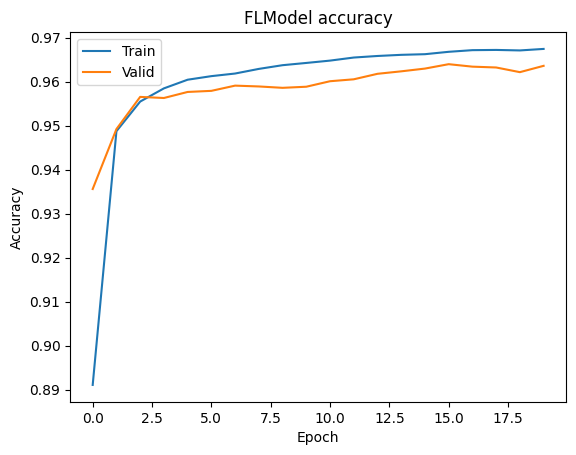

In [14]:
from matplotlib import pyplot as plt

# Draw accuracy values for training & validation
plt.plot(history["global_history"]['multiclassaccuracy'])
plt.plot(history["global_history"]['val_multiclassaccuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()